# 1. Install and Import Baseline Dependencies

In [1]:
pip list

Package                      Version
---------------------------- ---------
absl-py                      2.1.0
annotated-types              0.6.0
ansi2html                    1.8.0
anyio                        3.7.0
appnope                      0.1.3
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
async-lru                    2.0.2
attrs                        23.1.0
Babel                        2.12.1
backcall                     0.2.0
backoff                      2.2.1
beautifulsoup4               4.12.2
bleach                       6.0.0
blinker                      1.7.0
Brotli                       1.1.0
certifi                      2023.5.7
cffi                         1.15.1
charset-normalizer           3.1.0
click                        8.1.7
comm                         0.1.3
computer-vision              0.0.6
contextlib2                  21.6.0
cont

In [2]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.8 MB/s eta 0:00:009.2 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 25.0
    Uninstalling pip-25.0:
      Successfully uninstalled pip-25.0
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [11]:
!pip install transformers
!pip install torch

In [1]:
import nltk
#nltk.download('punkt')
from transformers import PegasusTokenizer, PegasusForConditionalGeneration, pipeline, BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, AlbertTokenizer, AlbertForSequenceClassification
from bs4 import BeautifulSoup
import requests
import re
import csv
import torch
from torch.optim import Adam
from nltk.tokenize import word_tokenize
import numpy as np

In [2]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/yash/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 2. Setup Summarization Model

In [3]:
model_name = "human-centered-summarization/financial-summarization-pegasus"
tokenizer_pegasus = PegasusTokenizer.from_pretrained(model_name)
model_pegasus = PegasusForConditionalGeneration.from_pretrained(model_name)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at human-centered-summarization/financial-summarization-pegasus and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 2.1 Setup Sentiment Analysis Models (BERT, RoBERTa, ALBERT)

In [4]:
model_name_bert = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer_bert = BertTokenizer.from_pretrained(model_name_bert)
model_bert = BertForSequenceClassification.from_pretrained(model_name_bert)

In [5]:
model_name_roberta = "roberta-large-mnli"
tokenizer_roberta = RobertaTokenizer.from_pretrained(model_name_roberta)
model_roberta = RobertaForSequenceClassification.from_pretrained(model_name_roberta)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
model_name_albert = "textattack/albert-base-v2-SST-2"
tokenizer_albert = AlbertTokenizer.from_pretrained(model_name_albert)
model_albert = AlbertForSequenceClassification.from_pretrained(model_name_albert)

# 3. Summarize a Single Article (Example - now a function)

In [9]:
url = "https://www.livemint.com/market/stock-market-news/latest-stock-market-news-on-march-3-2025-live-updates-11740960022242.html"
# url = "https://finance.yahoo.com/news/us-bitcoin-etf-inflows-near-035640575.html"
r = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser')
paragraphs = soup.find_all('p')

In [10]:
print(r.text)

<!DOCTYPE HTML><html lang="en"><head>
<meta charset="utf-8"><meta name="viewport" content="width=device-width, user-scalable=yes"><meta name="referrer" content="no-referrer-when-downgrade">
<meta name="robots" content="max-image-preview:large">
 <meta content="index,follow" name="robots">
<link rel="preload" as="image" href="https://www.livemint.com/lm-img/img/static/logo-mint2.svg" fetchpriority="high"/>
<link rel="preconnect" href="https://images.livemint.com"> <link rel="preconnect" href="https://www.googletagservices.com"> <link rel="preconnect" href="https://tpc.googlesyndication.com"><link rel="preconnect" href="https://securepubads.g.doubleclick.net"> <link rel="preconnect" href="https://adservice.google.com"> <link rel="preconnect" href="https://www.google.com"> <link rel="preconnect" href="https://adservice.google.co.in"><link rel="preconnect" href="https://googleads.g.doubleclick.net"> <link rel="preconnect" href="https://ads.pubmatic.com"> <link rel="preconnect" href="https:

In [11]:
paragraphs[0].text


'Stock Market News Today Live Updates: In an ever-evolving financial world, staying informed about stock market trends is crucial. Our Stock Market News provides real-time updates, insightful analysis, and in-depth coverage of the global financial landscape. From major index movements and corporate earnings to economic indicators and geopolitical events, we deliver the latest information impacting your investments and the broader economy. Our goal is to empower you with a clear understanding of market dynamics, investor sentiment, and potential opportunities, keeping you connected to the essential developments shaping the world of finance. Stay ahead with timely updates and expert perspectives on stock market trends.'

In [12]:
text = [paragraph.text for paragraph in paragraphs]
words = ' '.join(text).split(' ')[:400]
ARTICLE = ' '.join(words)

In [13]:
ARTICLE

"Stock Market News Today Live Updates: In an ever-evolving financial world, staying informed about stock market trends is crucial. Our Stock Market News provides real-time updates, insightful analysis, and in-depth coverage of the global financial landscape. From major index movements and corporate earnings to economic indicators and geopolitical events, we deliver the latest information impacting your investments and the broader economy. Our goal is to empower you with a clear understanding of market dynamics, investor sentiment, and potential opportunities, keeping you connected to the essential developments shaping the world of finance. Stay ahead with timely updates and expert perspectives on stock market trends.  Top Gainers and Losers Today : The Sensex lost 112.16 points, or -0.15, to settle at 73198.1, while the Nifty lost 5.4 points, or -0.02, to close at 22124.7.  Read the full story here   Top Gainers and Losers Today : The Sensex lost 112.16 points, or -0.15, to settle at 7

In [14]:
input_ids = tokenizer_pegasus.encode(ARTICLE, return_tensors='pt')
output = model_pegasus.generate(input_ids, max_length=55, num_beams=5, early_stopping=True)
summary = tokenizer_pegasus.decode(output[0], skip_special_tokens=True)

In [15]:
summary

'Indian stock markets face a continuous downtrend with five months of losses.'

In [16]:
# Step 1: Load pre-trained BERT model and tokenizer

# Step 2: Define a function for sentiment analysis
def analyze_sentiment(text):
    # Tokenize input text
    inputs = tokenizer_bert(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Pass tokens to the model
    with torch.no_grad():
        outputs = model_bert(**inputs)
    
    # Get predicted sentiment
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    # Map predicted class to sentiment label
    sentiment_labels = {
        0: "Very Negative",
        1: "Negative",
        2: "Neutral",
        3: "Positive",
        4: "Very Positive"
    }
    return sentiment_labels.get(predicted_class, "Unknown")

# Step 3: Test the function
text = summary
sentiment = analyze_sentiment(text)
print(f"Text: {text}")
print(f"Sentiment: {sentiment}")

Text: Indian stock markets face a continuous downtrend with five months of losses.
Sentiment: Very Negative


# 4. Building a News and Sentiment Pipeline

In [17]:
monitored_tickers = ['GME', 'TSLA', 'BTC']

## 4.1. Search for Stock News using Google and Yahoo Finance

In [18]:
def search_for_stock_news_urls(ticker):
    # Update the search URL to query CNBC Finance
    search_url = "https://www.google.com/search?q=cnbc+finance+{}&tbm=nws".format(ticker)
    r = requests.get(search_url)
    soup = BeautifulSoup(r.text, 'html.parser')
    atags = soup.find_all('a')
    hrefs = [link['href'] for link in atags]
    return hrefs

In [13]:
def search_for_stock_news_urls(ticker):
    search_url = "https://www.google.com/search?q=yahoo+finance+{}&tbm=nws".format(ticker)
    r = requests.get(search_url)
    soup = BeautifulSoup(r.text, 'html.parser')
    atags = soup.find_all('a')
    hrefs = [link['href'] for link in atags]
    return hrefs 

In [48]:
# Google finance
def search_for_stock_news_urls(ticker):
    search_url = "https://www.google.com/search?q=google+finance+{}&tbm=nws".format(ticker)
    r = requests.get(search_url)
    soup = BeautifulSoup(r.text, 'html.parser')
    atags = soup.find_all('a')
    hrefs = [link['href'] for link in atags]
    return hrefs

In [49]:
raw_urls = {ticker:search_for_stock_news_urls(ticker) for ticker in monitored_tickers}
raw_urls

{'GME': ['/?sa=X&ved=0ahUKEwjn2aXC5O2LAxXwSWwGHZuGNDgQOwgC',
  '/search?q=google+finance+GME&sca_esv=35aba76f9e0fd39c&ie=UTF-8&tbm=nws&gbv=1&sei=dY_FZ6fLOfCTseMPm43SwQM',
  '/search?q=google+finance+GME&sca_esv=35aba76f9e0fd39c&ie=UTF-8&source=lnms&sa=X&ved=0ahUKEwjn2aXC5O2LAxXwSWwGHZuGNDgQ_AUIBSgA',
  '/search?q=google+finance+GME&sca_esv=35aba76f9e0fd39c&ie=UTF-8&tbm=vid&source=lnms&sa=X&ved=0ahUKEwjn2aXC5O2LAxXwSWwGHZuGNDgQ_AUIBygC',
  '/search?q=google+finance+GME&sca_esv=35aba76f9e0fd39c&ie=UTF-8&tbm=isch&source=lnms&sa=X&ved=0ahUKEwjn2aXC5O2LAxXwSWwGHZuGNDgQ_AUICCgD',
  '/url?q=https://maps.google.com/maps%3Fq%3Dgoogle%2Bfinance%2BGME%26um%3D1%26ie%3DUTF-8%26ved%3D1t:200713%26ictx%3D111&opi=89978449&sa=U&ved=0ahUKEwjn2aXC5O2LAxXwSWwGHZuGNDgQiaAMCAkoBA&usg=AOvVaw0v8wS6g_y-BaTN-OmkYGBQ',
  '/url?q=/search%3Fq%3Dgoogle%2Bfinance%2BGME%26sca_esv%3D35aba76f9e0fd39c%26ie%3DUTF-8%26tbm%3Dshop%26source%3Dlnms%26ved%3D1t:200713%26ictx%3D111&opi=89978449&sa=U&ved=0ahUKEwjn2aXC5O2LAxXwSWwGH

In [50]:
raw_urls['GME']

['/?sa=X&ved=0ahUKEwjn2aXC5O2LAxXwSWwGHZuGNDgQOwgC',
 '/search?q=google+finance+GME&sca_esv=35aba76f9e0fd39c&ie=UTF-8&tbm=nws&gbv=1&sei=dY_FZ6fLOfCTseMPm43SwQM',
 '/search?q=google+finance+GME&sca_esv=35aba76f9e0fd39c&ie=UTF-8&source=lnms&sa=X&ved=0ahUKEwjn2aXC5O2LAxXwSWwGHZuGNDgQ_AUIBSgA',
 '/search?q=google+finance+GME&sca_esv=35aba76f9e0fd39c&ie=UTF-8&tbm=vid&source=lnms&sa=X&ved=0ahUKEwjn2aXC5O2LAxXwSWwGHZuGNDgQ_AUIBygC',
 '/search?q=google+finance+GME&sca_esv=35aba76f9e0fd39c&ie=UTF-8&tbm=isch&source=lnms&sa=X&ved=0ahUKEwjn2aXC5O2LAxXwSWwGHZuGNDgQ_AUICCgD',
 '/url?q=https://maps.google.com/maps%3Fq%3Dgoogle%2Bfinance%2BGME%26um%3D1%26ie%3DUTF-8%26ved%3D1t:200713%26ictx%3D111&opi=89978449&sa=U&ved=0ahUKEwjn2aXC5O2LAxXwSWwGHZuGNDgQiaAMCAkoBA&usg=AOvVaw0v8wS6g_y-BaTN-OmkYGBQ',
 '/url?q=/search%3Fq%3Dgoogle%2Bfinance%2BGME%26sca_esv%3D35aba76f9e0fd39c%26ie%3DUTF-8%26tbm%3Dshop%26source%3Dlnms%26ved%3D1t:200713%26ictx%3D111&opi=89978449&sa=U&ved=0ahUKEwjn2aXC5O2LAxXwSWwGHZuGNDgQiaAMCAo

## 4.2. Strip out unwanted URLs

In [51]:
import re

In [52]:
exclude_list = ['maps', 'policies', 'preferences', 'accounts', 'support']

In [53]:
def strip_unwanted_urls(urls, exclude_list):
    val = []
    for url in urls: 
        if 'https://' in url and not any(exclude_word in url for exclude_word in exclude_list):
            res = re.findall(r'(https?://\S+)', url)[0].split('&')[0]
            val.append(res)
    return list(set(val))

In [54]:
cleaned_urls = {ticker:strip_unwanted_urls(raw_urls[ticker], exclude_list) for ticker in monitored_tickers}
cleaned_urls

{'GME': ['https://medium.datadriveninvestor.com/i-used-ai-to-predict-the-gamestop-gme-frenzy-8aaa5aac4e5e',
  'https://www.investopedia.com/5-things-to-know-before-the-stock-market-opens-december-10-2024-8758727',
  'https://www.tradingview.com/news/todayq:78b27648c094b:0-strive-sends-letter-to-gamestop-advising-investing-into-btc/',
  'https://www.tokenpost.com/GameStop-Jumps-300-as-Roaring-Kitty-Takes-Huge-GME-Call-Options-11950',
  'https://finance.yahoo.com/video/gamestop-earnings-google-apple-august-210707491.html',
  'https://finance.yahoo.com/news/live/stock-market-today-nasdaq-soars-to-record-as-tesla-google-amazon-apple-hit-fresh-highs-210100728.html',
  'https://www.tradingview.com/news/cointelegraph:01fa12ac0094b:0-gamestop-rises-18-after-hours-on-reports-it-s-considering-investing-in-bitcoin/',
  'https://www.investors.com/market-trend/stock-market-today/dow-jones-sp500-nasdaq-cpi-inflation-gamestop-gme-stock/',
  'https://cointelegraph.com/news/gamestop-bitcoin-buys-would-

## 4.3. Search and Scrape Cleaned URLs

In [55]:
def scrape_and_process(URLs, max_words=350):
    ARTICLES = []
    for url in URLs:
        try:  # Added try-except to handle potential errors during scraping
            r = requests.get(url)
            soup = BeautifulSoup(r.text, 'html.parser')
            paragraphs = soup.find_all('p')
            text = [paragraph.text for paragraph in paragraphs]
            words = ' '.join(text).split(' ')[:max_words]
            ARTICLE = ' '.join(words)
            ARTICLES.append(ARTICLE)
        except Exception as e:
            print(f"Error scraping {url}: {e}")
            ARTICLES.append('')  # Append empty string for failed scrapes
    return ARTICLES

In [56]:
articles = {ticker:scrape_and_process(cleaned_urls[ticker]) for ticker in monitored_tickers}
articles

{'GME': ['Sign up Sign in Sign up Sign in Austin Starks Follow DataDrivenInvestor -- 1 Listen Share This isn’t the first time I’ve witnessed the GameStop rally. On Jan 27th, 2021 my twin brother and I saw the first GameStop rally in real-time. It was an insane time to be a trader, seeing a stock that was worth a couple bucks a share catapult to being over $400 a pop. The parabolic rally was then cut short when Robinhood and other major brokerages halted buying shares of GME. The momentum in the rally fizzled out, and GameStop slowly faded down back to $15/share. In that timeframe, most people outside of the most devout followers sold their shares of GameStop. Fast forward to years later, exactly 3 months ago on February 13th, I wrote an article that utilizes large language models and GameStop fundamental data, and determined whether GME was a good buy fundamentally. Fundamental data is data that evaluates a company’s overall health. It might be the amount of cash the business is bringi

In [57]:
articles['TSLA'][0]

'Markets \n\n\n Hot Stocks \n\n\n Fear & Greed Index \n\n\n \n            Latest Market News \n\n\n \n            Hot Stocks \n\n\n \n            Demonstrators gathered at more than 50 Tesla showrooms across the United States on Saturday in protest of CEO Elon Musk’s role in slashing government agencies as part of the so-called Department of Government Efficiency established by President Donald Trump.\n     \n            The protests are part of “Tesla Takedown,” which, according to its website, hopes to encourage stakeholders to “sell your Teslas, dump your stock, join the picket lines.”\n     \n            “Creating a vote of no confidence in him from the shareholders, that would be the ultimate goal,” Alex Winter, a Los Angeles-based actor and filmmaker who is one of the main organizers, told CNN.\n     \n            The first Tesla Takedown protest was on February 15 after Winter spoke with Joan Donovan, a sociologist and professor at Boston University, who suggested a Tesla protes

## 4.4. Summarise all Articles

In [58]:
def summarize(articles, max_length=55):
    summaries = []
    for article in articles:
        if article:  # Avoid processing empty articles
           input_ids = tokenizer_pegasus.encode(article, return_tensors='pt')
           output = model_pegasus.generate(input_ids, max_length=max_length, num_beams=5, early_stopping=True)
           summary = tokenizer_pegasus.decode(output[0], skip_special_tokens=True)
        else:
           summary = '' # Append empty string for failed scrapes

        summaries.append(summary)
    return summaries

In [59]:
summaries = {ticker:summarize(articles[ticker]) for ticker in monitored_tickers}
summaries

{'GME': ['GameStop is on its 2nd parabolic short squeeze rally. It’s a profitable company, unlike AMC',
  '',
  'Video game retailer has confirmed that it has received a letter from Strive Asset Management.',
  'Roaring Kitty reveals $181.4 million GME call options and stock investment.',
  '',
  '',
  'Shares have since cooled slightly, falling to $28.36 in after-hours trading. Gaming retailer previously made forays into crypto space',
  'All photographs are copyrighted.',
  '',
  'Your information may be shared with third parties.',
  'Cohen shared a photo with Strategy co-founder. Shares of the video game retailer are down nearly 14% so far in 2025'],
 'TSLA': ['Protests are part of ‘Tesla Takedown,’ organizers say. Musk’s role has received criticism at the start',
  'Lava O3 15,799 Apple iPhone 16e 5G 159,900, Realme P3x 5G 113,999, Itel Zeno.',
  'Shares are down 30% in February, putting them on track for second-worst month. Musk’s close association with Trump is a distraction',
 

In [60]:
summaries['BTC']

['Video game retailer has confirmed that it has received a letter from Strive Asset Management.',
 'Your information may be shared with third parties.',
 'Vivo Y300 Plus 5G, Realme P1 Speed, Lava Agni 3 among latest smartphone launches',
 'You have recently performed an action that caused this block.',
 'Analysts at QCP Capital expect Bitcoin to remain range-bound. Google’s new ‘Willow’ chip raises security concerns',
 'Metaplanet CEO says firm is exploring a potential U.S. listing. The firm is aiming to accumulate 21,000 Bitcoin by 2026',
 '',
 '',
 'New accounting rules allow companies to adjust value of digital assets. Tesla is the fourth-largest publicly traded Bitcoin holder',
 'Google Finance makes it easy to track stocks and keep up with your portfolio.',
 'Live price charts for Bitcoin, Ether, and other cryptos have been removed. It’s unclear whether this is a temporary glitch or a permanent decision']

# 4.5 Sentiment Analysis

In [61]:
def analyze_sentiment(texts, tokenizer, model):
    results = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            logits = model(**inputs).logits
        predicted_class = torch.argmax(logits, dim=1).item()
        sentiment = model.config.id2label[predicted_class]
        score = torch.softmax(logits, dim=1)[0][predicted_class].item()
        results.append({"label": sentiment, "score": score})
    return results

In [62]:
# Analyze sentiment for each ticker
sentiment_results = {
    "bert": {ticker: analyze_sentiment(summaries[ticker], tokenizer_bert, model_bert) for ticker in monitored_tickers},
    "roberta": {ticker: analyze_sentiment(summaries[ticker], tokenizer_roberta, model_roberta) for ticker in monitored_tickers},
    "albert": {ticker: analyze_sentiment(summaries[ticker], tokenizer_albert, model_albert) for ticker in monitored_tickers},
}

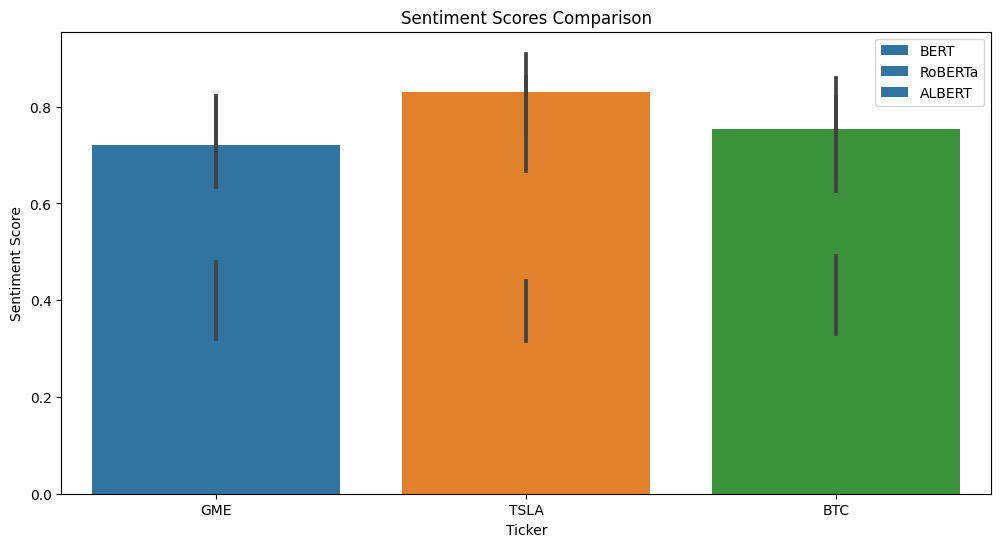

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame for visualization
data = []
for ticker in monitored_tickers:
    for i, summary in enumerate(summaries[ticker]):
        data.append({
            "Ticker": ticker,
            "Summary": summary,
            "BERT Sentiment": sentiment_results["bert"][ticker][i]["label"],
            "BERT Score": sentiment_results["bert"][ticker][i]["score"],
            "RoBERTa Sentiment": sentiment_results["roberta"][ticker][i]["label"],
            "RoBERTa Score": sentiment_results["roberta"][ticker][i]["score"],
            "ALBERT Sentiment": sentiment_results["albert"][ticker][i]["label"],
            "ALBERT Score": sentiment_results["albert"][ticker][i]["score"],
            "URL": cleaned_urls[ticker][i]
        })

df = pd.DataFrame(data)

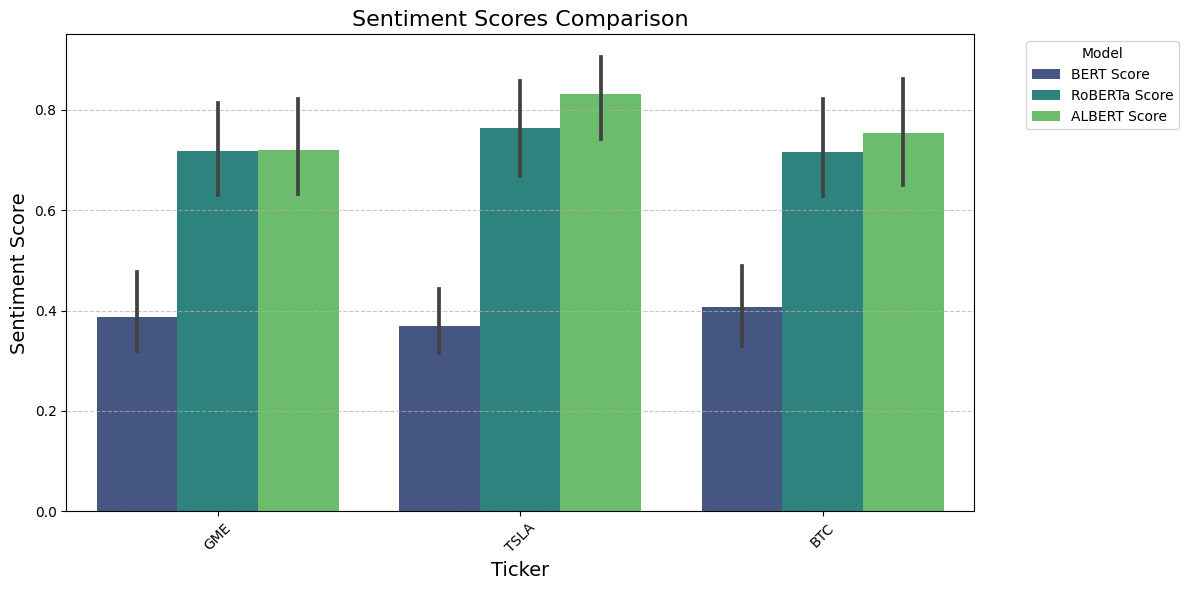

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your DataFrame with columns: Ticker, BERT Score, RoBERTa Score, ALBERT Score

# Melt the DataFrame to long format for easier plotting with seaborn
df_melted = df.melt(id_vars=["Ticker"], value_vars=["BERT Score", "RoBERTa Score", "ALBERT Score"],
                    var_name="Model", value_name="Score")

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x="Ticker", y="Score", hue="Model", data=df_melted, palette="viridis")
plt.title("Sentiment Scores Comparison", fontsize=16)
plt.xlabel("Ticker", fontsize=14)
plt.ylabel("Sentiment Score", fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add grid lines for the y-axis
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")  # Place legend outside the plot
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [64]:
# Export to CSV
df.to_csv("sentiment_analysis_google.csv", index=False)